In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_val_predict,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso
from sklearn.metrics import r2_score,accuracy_score
from sklearn.tree import DecisionTreeRegressor
import xgboost
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import nan
import pickle

In [2]:
dataset=pd.read_csv('mercedesbenz.csv')
dataset

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def load_data(dataset):
    if 'y' in dataset.columns:
        X=dataset.drop(columns=['y','ID'])
        y=dataset['y']
        IQR=y.quantile(0.75)-y.quantile(0.25)
        upper_threshold=y.median()+3*IQR
        lower_threshold=y.median()-3*IQR
        y=pd.DataFrame(np.where(y>upper_threshold,upper_threshold,y),columns=['y'])
        return X,y
    elif 'ID' in dataset.columns:
        X=dataset.drop(columns=['ID'])
        return X
    else:
        X=dataset.copy()
        return X

In [4]:
minmax=MinMaxScaler(feature_range=(0,1))
scaler=StandardScaler()
le=LabelEncoder()
oe=OrdinalEncoder()
ohe=OneHotEncoder(sparse=False,drop='first')
def preprocessing(datset,X):
    global num_removed_cols
    num_removed_cols=[]
    global cat_encoded_cols
    cat_encoded_cols=[]
    global cat_cols
    global num_cols
    cat_cols=X.select_dtypes(include='object').columns.values.tolist()
    num_cols=X.select_dtypes(exclude='object').columns.values.tolist()
    for col in num_cols:
        if X[col].nunique()==1:
            num_removed_cols.append(col)
    for col in cat_cols:
        Mean_encoded_col=dataset.groupby(col)['y'].median().sort_values(ascending=True).index
        encoded_col={k:i for i,k in enumerate(Mean_encoded_col,0)}
        encoded_dict={col:encoded_col}
        cat_encoded_cols.append(encoded_dict)
    return num_removed_cols,cat_encoded_cols

In [5]:
def transformation(X):
    for col in num_removed_cols:
        X=X.drop(labels=col,axis=1)
    for cols in cat_encoded_cols:
        for key,values in cols.items():
            for col in cat_cols:
                if key==col:
                    X[col]=X[col].map(values)
                    X[[col]]=scaler.fit_transform(X[[col]])
    return X

In [6]:
# def transformation(X):
#     for col in num_removed_cols:
#         if col in X.columns:
#             X=X.drop(labels=col,axis=1)
#         else:
#             continue
#     for cols in cat_encoded_cols:
#         for key,values in cols.items():
#             if key in X.columns:
#                 for col in cat_cols:
#                     if key==col:
#                         X[col]=X[col].map(values)
#                         X[[col]]=scaler.fit_transform(X[[col]])
#             else:
#                 continue
#     return X

In [7]:
def feature_selection(X,y):
    Selector=SelectKBest(score_func=f_regression,k=20)
    Selector.fit(X,y)
    X_new=Selector.fit_transform(X,y)
    X_new=pd.DataFrame(Selector.fit_transform(X,y),columns=X.columns[Selector.get_support()])
    global selected_columns
    selected_columns=X.columns[Selector.get_support()]
    return X_new

In [8]:
models={'Linear Regression':LinearRegression(),'Ridge Regression':Ridge(),'Lasso Regression':Lasso(),'Decision Tree':DecisionTreeRegressor(),
       'XGBoost':xgboost.XGBRegressor(),'AdaBoost':AdaBoostRegressor(),'Bagging Regressor':BaggingRegressor(),'Gradient Boosting':GradientBoostingRegressor(),
       'Random Forest': RandomForestRegressor()}
def train_model(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    for model_names,model in models.items():
        if model_names=='XGBoost' :
            params={
                     "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                     "min_child_weight" : [ 1, 3, 5, 7 ],
                     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ], 
                    }
            xgboost_test=RandomizedSearchCV(model,param_distributions=params,n_iter=15,\
                                 scoring='r2',n_jobs=-1,cv=5,verbose=8,random_state=42)
            # estimator=xgboost_test.best_estimator_
            # regressor=
            xgboost_model=xgboost_test.fit(X_train,y_train)
            xgboost_train=xgboost_model.predict(X_train)
            xgboost_pred=xgboost_model.predict(X_test)
            print('The accuracy for train is',r2_score(y_train,xgboost_train))
            print('The accuracy for test is',r2_score(y_test,xgboost_pred))
            pickle.dump(xgboost_test,open('XGBoost_regression.pkl','wb'))
            predictions=pd.DataFrame()
            predictions['y_train_true']=y_train
            predictions['y_train_pred']=xgboost_train.tolist()
            test_predictions=pd.DataFrame()
            test_predictions['y_test_true']=y_test
            test_predictions['y_test_pred']=xgboost_pred.tolist()
            return predictions,test_predictions
        else:
            continue

In [9]:
def modelling():
    global y
    X,y=load_data(dataset)
    print(X)
    preprocessing(dataset,X)
    X=transformation(X)
    print('--------------------------')
    print(X)
    X=feature_selection(X,y)
    print('--------------------------')
    print(X)
    predictions,test_predictions=train_model(X,y)
    print('--------------------------')
    return X
# X=modelling()
# X

In [10]:
def test_model(data):
    modelling()
    global X
    X=load_data(data)
    X=transformation(X)
    X=X[selected_columns]
    xgboost_model=pickle.load(open('XGBoost_regression.pkl','rb'))
    predictions=pd.DataFrame(index=data['ID'])
    predictions['y']=xgboost_model.predict(X)
    return predictions

In [11]:
# selected_columns

In [12]:
X0='k'
X2='at'
X29=0
X54=0
X76=0
X127=0
X136=1
X162=0
X166=0
X178=0
X232=0
X250=0
X261=0
X263=1
X272=0
X276=0
X279=0
X313=0
X314=0
X328=0

In [13]:
data1=pd.DataFrame([[X0, X2, X29, X54, X76, X127, X136, X162, X166, X178,X232, X250, X261, X263, X272, 
        X276, X279, X313, X314,X328]],columns=['X0', 'X2', 'X29', 'X54', 'X76', 'X127', 'X136',' X162', 'X166', 'X178','X232', 'X250', 'X261', 'X263', 'X272','X276', 'X279', 'X313', 'X314','X328'])
data1

,X0,X2,X29,X54,X76,X127,X136,X162,X166,X178,X232,X250,X261,X263,X272,X276,X279,X313,X314,X328
0,k,at,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [14]:
def app_transformation(X):
    for cols in cat_encoded_cols:
        for key,values in cols.items():
            if key in X.columns:
                X[key]=X[key].map(values)
                X[[key]]=scaler.transform(X[[key]])
            else:
                continue
    return X

In [15]:
def app_model(data):
    modelling()
    X=load_data(data)
    X=app_transformation(X)
    xgboost_model=pickle.load(open('XGBoost_regression.pkl','rb'))
    predictions=xgboost_model.predict(X)
    return predictions

In [16]:
def modelling():
    global y
    X,y=load_data(dataset)
    print(X)
    preprocessing(dataset,X)
    X=transformation(X)
    print('--------------------------')
    print(X)
    X=feature_selection(X,y)
    print('--------------------------')
    print(X)
    # predictions,test_predictions=train_model(X,y)
    print('--------------------------')
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    return X_train,X_test,y_train,y_test
X_train,X_test,y_train,y_test=modelling()
X_train

      X0 X1  X2 X3 X4  X5 X6 X8  X10  X11  ...  X375  X376  X377  X378  X379  \
0      k  v  at  a  d   u  j  o    0    0  ...     0     0     1     0     0   
1      k  t  av  e  d   y  l  o    0    0  ...     1     0     0     0     0   
2     az  w   n  c  d   x  j  x    0    0  ...     0     0     0     0     0   
3     az  t   n  f  d   x  l  e    0    0  ...     0     0     0     0     0   
4     az  v   n  f  d   h  d  n    0    0  ...     0     0     0     0     0   
...   .. ..  .. .. ..  .. .. ..  ...  ...  ...   ...   ...   ...   ...   ...   
4204  ak  s  as  c  d  aa  d  q    0    0  ...     1     0     0     0     0   
4205   j  o   t  d  d  aa  h  h    0    0  ...     0     1     0     0     0   
4206  ak  v   r  a  d  aa  g  e    0    0  ...     0     0     1     0     0   
4207  al  r   e  f  d  aa  l  u    0    0  ...     0     0     0     0     0   
4208   z  r  ae  c  d  aa  g  w    0    0  ...     1     0     0     0     0   

      X380  X382  X383  X384  X385  
0 

,X0,X2,X29,X54,X76,X127,X136,X162,X166,X178,X232,X250,X261,X263,X272,X276,X279,X313,X314,X328
1006,-0.093689,0.646145,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1840,-0.949706,0.646145,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3792,-0.474141,-0.800287,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
152,1.047666,1.870049,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1557,0.191650,0.646145,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,1.047666,0.646145,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
466,-1.995949,-0.355231,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3092,-0.854593,-0.689023,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3772,-0.854593,-0.466495,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
import tensorflow

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import PReLU,ReLU,LeakyReLU,ELU
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers

In [19]:
tf_regressor=Sequential()

In [20]:
tf_regressor.add(Dense(units=20,activation='relu'))

In [21]:
tf_regressor.add(Dense(units=10,activation='relu'))
tf_regressor.add(Dropout(0.2))

In [22]:
tf_regressor.add(Dense(units=5,activation='relu'))
tf_regressor.add(Dropout(0.2))

In [23]:
tf_regressor.add(Dense(1))

In [24]:
# tf_regressor.add(Dense(units=1,activation='softmax'))

In [25]:
opt=optimizers.Adam(learning_rate=0.01)

In [26]:
early_stopping=tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [27]:
tf_regressor.compile(optimizer=opt,loss='mse',metrics=['mse'])

In [28]:
model_history=tf_regressor.fit(X_train,y_train,validation_split=0.33,batch_size=10,epochs=1000,callbacks=early_stopping)

Epoch 1/1000
226/226 [==============================] - 2s 4ms/step - loss: 3636.8162 - mse: 3636.8159 - val_loss: 473.3836 - val_mse: 473.3836
Epoch 2/1000
226/226 [==============================] - 1s 3ms/step - loss: 1685.0171 - mse: 1685.0172 - val_loss: 334.8333 - val_mse: 334.8333
Epoch 3/1000
226/226 [==============================] - 1s 3ms/step - loss: 1528.1923 - mse: 1528.1923 - val_loss: 274.1424 - val_mse: 274.1424
Epoch 4/1000
226/226 [==============================] - 1s 3ms/step - loss: 1529.5751 - mse: 1529.5751 - val_loss: 283.2690 - val_mse: 283.2689
Epoch 5/1000
226/226 [==============================] - 1s 3ms/step - loss: 1555.6781 - mse: 1555.6781 - val_loss: 250.9958 - val_mse: 250.9958
Epoch 6/1000
226/226 [==============================] - 1s 3ms/step - loss: 1481.9357 - mse: 1481.9357 - val_loss: 255.4814 - val_mse: 255.4814
Epoch 7/1000
226/226 [==============================] - 1s 3ms/step - loss: 1334.0345 - mse: 1334.0345 - val_loss: 504.9772 - val_mse: 5

In [ ]:
# model_history=tf_regressor.fit(X_train,y_train,validation_split=0.33,batch_size=10,epochs=1000,callbacks=early_stopping)

In [30]:
model_history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

In [31]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

KeyError: 'accuracy'

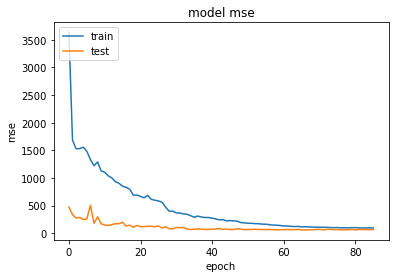

In [29]:
plt.plot(model_history.history['mse'])
plt.plot(model_history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

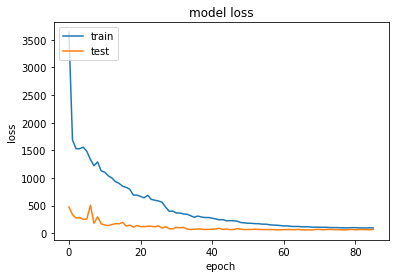

In [30]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [41]:
X_test.index

Int64Index([1073,  144, 2380,  184, 2587, 2768, 3697,  999, 2856, 2862,
            ...
            2528, 4171, 2771, 1032, 3273,  657, 3975,  907, 3597, 1971],
           dtype='int64', length=842)

In [71]:
y_test

,y
1073,97.94
144,96.41
2380,105.83
184,79.09
2587,108.69
...,...
657,113.68
3975,88.85
907,89.60
3597,89.23


In [81]:
y_pred

,id,y_pred
0,1073,94.222771
1,144,94.222771
2,2380,110.177139
3,184,83.635834
4,2587,112.371704
...,...,...
837,657,109.427353
838,3975,94.222771
839,907,94.222771
840,3597,94.222771


In [82]:
y_test

,y
1073,97.94
144,96.41
2380,105.83
184,79.09
2587,108.69
...,...
657,113.68
3975,88.85
907,89.60
3597,89.23


In [31]:
y_pred=tf_regressor.predict(X_test)
y_pred=pd.DataFrame(y_pred,columns=['y_pred'])
# y_pred.index=X_test.index
final=y_pred.merge(y_test,on=y_test.index)
# Dummy=Dummy.set_index('key_0')
# Dummy=Dummy.rename_axis('id')
# Dummy.rename()
final=final.rename(columns={'key_0':'id'})
final['% Error']=(final['y']-final['y_pred'])/final['y']*100
final

27/27 [==============================] - 0s 1ms/step


,id,y_pred,y,% Error
0,1073,94.322876,97.94,3.693204
1,144,94.830124,96.41,1.638706
2,2380,108.558357,105.83,-2.578057
3,184,89.762878,79.09,-13.494599
4,2587,109.609200,108.69,-0.845708
...,...,...,...,...
837,657,108.145828,113.68,4.868202
838,3975,94.637497,88.85,-6.513784
839,907,94.931816,89.60,-5.950688
840,3597,94.830124,89.23,-6.276055


In [119]:
y_pred=tf_regressor.predict(X_test)
y_pred=pd.DataFrame(y_pred,columns=['y_pred'])
# y_pred.index=X_test.index
final=y_pred.merge(y_test,on=y_test.index)
# Dummy=Dummy.set_index('key_0')
# Dummy=Dummy.rename_axis('id')
# Dummy.rename()
final=final.rename(columns={'key_0':'id'})
final['% Error']=(final['y']-final['y_pred'])/final['y']*100
final

27/27 [==============================] - 0s 2ms/step


,id,y_pred,y,% Error
0,1073,94.222771,97.94,3.795415
1,144,94.222771,96.41,2.268675
2,2380,110.177139,105.83,-4.107663
3,184,83.635834,79.09,-5.747672
4,2587,112.371704,108.69,-3.387344
...,...,...,...,...
837,657,109.427353,113.68,3.740893
838,3975,94.222771,88.85,-6.047013
839,907,94.222771,89.60,-5.159342
840,3597,94.222771,89.23,-5.595395


In [32]:
final.describe()

,id,y_pred,y,% Error
count,842.000000,842.000000,842.000000,842.000000
mean,2006.460808,100.115723,100.596354,-0.343262
std,1222.681278,6.914712,12.452029,7.697863
min,6.000000,89.762878,72.940000,-23.063996
25%,936.250000,94.646391,90.900000,-4.918482
50%,1995.000000,95.013702,98.600000,-1.121313
75%,3068.500000,107.843567,109.110000,2.841627
max,4208.000000,153.647873,153.720000,32.405679


In [111]:
Dummy.describe()

NameError: name 'Dummy' is not defined

In [ ]:
y_pred=tf_regressor.predict(X_test)
y_pred=pd.DataFrame(y_pred,columns=['y_pred'])
# y_pred.index=X_test.index
Dummy=y_pred.merge(y_test,on=y_test.index)
# Dummy=Dummy.set_index('key_0')
# Dummy=Dummy.rename_axis('id')
# Dummy.rename()
Dummy=Dummy.rename(columns={'key_0':'id'})
Dummy['% Error']=(Dummy['y']-Dummy['y_pred'])/Dummy['y']*100
Dummy
# y_pred.set_index('id')
# y_pred
# y_pred=y_pred.set_index('id').reset_index()
# Dummy=y_pred.merge(y_test,how='left',on=y_test.index)
# Dummy
# y_pred=pd.DataFrame(y_pred,columns=['y_pred'])
# y_pred['id']=X_test.index
# y_pred=y_pred.set_index('id')
# Dummy=pd.concat(y_pred,y_test.values)
# Dummy